# Assignment 2 -- COMP 4900
### Student: Tri Cao (100971065) & Hien Le (101044264)

---


# 1. Summary

This notebook contains implementations and data analysis details for the second homework, as a detailed reference for our finding. For more compact result please refer to the report.pdf

---



# 2. Data Analysis

## 1. Import data

- Make sure to upload the `train.csv` and `test.csv` data
- Import python libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline

- Using `Pandas` to read the _csv_ files

In [0]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

train_df.head(5)

,review,sentiment
0,I should have never watched this movie. The st...,negative
1,Robert Lansing plays a scientist experimenting...,negative
2,I was looking forward to this movie. Trustwort...,negative
3,Where to start? Some guy has some Indian pot t...,negative
4,What happened? What we have here is basically ...,negative


In [0]:
test_df.head(5)

,id,review
0,0,deals with the issue of Nazism and the vilific...
1,1,/><br />What Rambo does not realise is that he...
2,2,I found it charming! Nobody else but Kiarostam...
3,3,"I just don't know how this stupid, crap, junk,..."
4,4,"Hey guys, <br /><br />i have been looking ever..."


## 2. Prepare data-cleaning models for the pipeline

  - There are multiple techniques to analyze and prepare the data to achieve the best results for our models
  - Here we are creating a Sklearn's Pipeline to preprocess the data


In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1. Remove non-word characters

- This model will remove non-word character from the whole dataset
- This includes removing punctuations and numeric characters

In [0]:
class ExtractNonwordCharacters(BaseEstimator):
    """ remove numbers and non-word characters, such as, < > _
    """
    def __init__(self, number=True, non_words=True):
        self.number = number
        self.non_words = non_words

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        # remove numbers
        if self.number:
            x = x.str.replace("\d+", "")

        # remove non-word characters
        if self.non_words:
            x = x.str.replace("<br />", "", regex=False)
            x = x.str.replace("[^\w\s]", "")
            x = x.replace(r"_", "", regex=True)
        return x

In [0]:
print("Before: \n", train_df.review[:1][0])
print("\nAfter:\n", ExtractNonwordCharacters().transform(train_df.review[:1])[0])

Before: 
 I should have never watched this movie. The style of filming may be considered artsy to some, but it is considered migraine-inducing to me. I think it may have had an interesting plot, but since I couldn't watch it for long stretches at a time I missed a lot. The flickering pictures and stop motion filming branded my brain. I stopped watching mid way through and won't be back for a second try. I suppose if I were home alone in my own lighthouse some dark and stormy evening, this might be just the ticket... PS Not sure if the lighthouse/ film style thing can be considered a spoiler, but I don't want to be blacklisted on my first review ;)

After:
 I should have never watched this movie The style of filming may be considered artsy to some but it is considered migraineinducing to me I think it may have had an interesting plot but since I couldnt watch it for long stretches at a time I missed a lot The flickering pictures and stop motion filming branded my brain I stopped watchin

### 2. Remove stopwords

- Stopwords don't help us to find the context or the true meaning of a sentence.
- Thus, they need to to be removed from our datasets

In [0]:
class ExtractStopwords(BaseEstimator):
    """ 
    Remove stopwords from dataset and words that have less than 2 letters
    for example, 'the car' --> 'car'
    """
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))

    def fit(self, x, y=None):
        return self

    def remove_stopwords(self, doc):
        words_list = [w for w in doc.split() if (w not in self.stop_words) and len(w) > 2]
        return " ".join(words_list)

    def transform(self, x):
        x = map(self.remove_stopwords, x)
        x = np.array(list(x))
        return x

In [0]:
print("Before: \n", train_df.review[:1][0])
print("\nAfter:\n", ExtractStopwords().transform(train_df.review[:1])[0])

Before: 
 I should have never watched this movie. The style of filming may be considered artsy to some, but it is considered migraine-inducing to me. I think it may have had an interesting plot, but since I couldn't watch it for long stretches at a time I missed a lot. The flickering pictures and stop motion filming branded my brain. I stopped watching mid way through and won't be back for a second try. I suppose if I were home alone in my own lighthouse some dark and stormy evening, this might be just the ticket... PS Not sure if the lighthouse/ film style thing can be considered a spoiler, but I don't want to be blacklisted on my first review ;)

After:
 never watched movie. The style filming may considered artsy some, considered migraine-inducing me. think may interesting plot, since watch long stretches time missed lot. The flickering pictures stop motion filming branded brain. stopped watching mid way back second try. suppose home alone lighthouse dark stormy evening, might ticket

### 3. Lemmatize reviews

- Since some words mean the same but have different part of speech and in different tense. For example, `am`, `is`, `are`
- we need to lemmatize them to reduce the size of the dataset

In [0]:
class Lemmatizer(BaseEstimator):
    """ Lemmatize dataset
    for example, convert 'is', 'am', 'are' --> 'be'
    """
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def get_wordnet_pos(self, word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV,
        }
        return tag_dict.get(tag, wordnet.NOUN)

    def fit(self, x, y=None):
        return self

    def lemma(self, doc):
        words_list = [
            self.wnl.lemmatize(w, self.get_wordnet_pos(w)) for w in doc.split()
        ]
        return " ".join(words_list)

    def transform(self, x):
        x = map(self.lemma, x)
        x = np.array(list(x))
        return x

In [0]:
print("Before: \n", train_df.review[:1][0])
print("\nAfter:\n", Lemmatizer().transform(train_df.review[:1])[0])

Before: 
 I should have never watched this movie. The style of filming may be considered artsy to some, but it is considered migraine-inducing to me. I think it may have had an interesting plot, but since I couldn't watch it for long stretches at a time I missed a lot. The flickering pictures and stop motion filming branded my brain. I stopped watching mid way through and won't be back for a second try. I suppose if I were home alone in my own lighthouse some dark and stormy evening, this might be just the ticket... PS Not sure if the lighthouse/ film style thing can be considered a spoiler, but I don't want to be blacklisted on my first review ;)

After:
 I should have never watch this movie. The style of film may be consider artsy to some, but it be consider migraine-inducing to me. I think it may have have an interest plot, but since I couldn't watch it for long stretch at a time I miss a lot. The flicker picture and stop motion film brand my brain. I stop watch mid way through and 

### 4. Stem reviews

- Similar to lemmatization, Stemming is the process to reduce inflected (or sometimes derived) words to their word stem

In [0]:
class Stemmer(BaseEstimator):
    """ 
    stem words by removing some characters at the end of the wood
    for example, 'beautiful'  -->  'beauti'
    """
    def __init__(self):
        self.stemmer = PorterStemmer()

    def fit(self, x, y=None):
        return self

    def stem(self, doc):
        words_list = [
            self.stemmer.stem(w) for w in doc.split()
        ]
        return " ".join(words_list)

    def transform(self, x):
        x = map(self.stem, x)
        x = np.array(list(x))
        return x

In [0]:
print("Before: \n", train_df.review[:1][0])
print("\nAfter:\n", Stemmer().transform(train_df.review[:1])[0])

Before: 
 I should have never watched this movie. The style of filming may be considered artsy to some, but it is considered migraine-inducing to me. I think it may have had an interesting plot, but since I couldn't watch it for long stretches at a time I missed a lot. The flickering pictures and stop motion filming branded my brain. I stopped watching mid way through and won't be back for a second try. I suppose if I were home alone in my own lighthouse some dark and stormy evening, this might be just the ticket... PS Not sure if the lighthouse/ film style thing can be considered a spoiler, but I don't want to be blacklisted on my first review ;)

After:
 I should have never watch thi movie. the style of film may be consid artsi to some, but it is consid migraine-induc to me. I think it may have had an interest plot, but sinc I couldn't watch it for long stretch at a time I miss a lot. the flicker pictur and stop motion film brand my brain. I stop watch mid way through and won't be ba

### 5. Finally, Run the Pipeline
- We have created both stemmed data and lemmztized data, however the result show no difference, thus here we only create a Pipeline for the `Lemmatizer()`

- Convert the label (sentiment) to `1` and `0`

In [0]:
train_df.sentiment = train_df.sentiment.astype("category").cat.codes
train_df.sentiment

0        0
1        0
2        0
3        0
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: sentiment, Length: 30000, dtype: int8

- Initialize the Pipeline with desired models

In [0]:
review_pipeline = Pipeline([("Extract-Nonwords", ExtractNonwordCharacters()),
                            ("Extract-Stopwords", ExtractStopwords()),
                            ("Lemmatizer", Lemmatizer())])

- Fit and transform both train and test sets

In [0]:
train_df.review = review_pipeline.fit_transform(train_df.review)
test_df.review = review_pipeline.transform(test_df.review)

In [0]:
# cleaned train data
train_df.head(5)

,review,sentiment
0,never watch movie The style film may consider ...,0
1,Robert Lansing play scientist experiment passi...,0
2,look forward movie Trustworthy actor interest ...,0
3,Where start Some guy Indian pot he cleaning su...,0
4,What happen What basically solid plausible pre...,0


In [0]:
# clean test data
test_df.head(5)

,id,review
0,0,deal issue Nazism vilification Germans period ...
1,1,What Rambo realise set Trautman portrayed brav...
2,2,found charm Nobody else Kiarostami little yet ...
3,3,dont know stupid crap junk garbage good nothin...
4,4,Hey guy look every find two movie cant find an...


# 3. Vectorization

### 1. Split the train data


In [0]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(train_df.review, train_df.sentiment, test_size=0.2, random_state=111)

print("X_train: ", X_train_df.shape)
print("X_test : ", X_test_df.shape)
print("y_train: ", y_train_df.shape)
print("y_test: ", y_test_df.shape)

X_train:  (24000,)
X_test :  (6000,)
y_train:  (24000,)
y_test:  (6000,)


### 2. Vectorize the train and test data

- Here we taking the top 20,000 words inluding unigram and bigram
- Set binaty to `True` and ignores words that occur less than 4 times

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(max_features=20000, ngram_range=(1, 2), binary=True, min_df=4, max_df=0.7)

X_train = count_vec.fit_transform(X_train_df)
X_test = count_vec.transform(X_test_df)
actual_test = count_vec.transform(test_df.review)

In [0]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Actual Test: ", actual_test.shape)

X_train:  (24000, 20000)
X_test:  (6000, 20000)
Actual Test:  (10000, 20000)


- Convert test sets to numpy array

In [0]:
y_train = y_train_df.to_numpy()
y_test = y_test_df.to_numpy()

print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

y_train:  (24000,)
y_test:  (6000,)


### 3. Data vocabulary

In [0]:
import matplotlib.pyplot as plt

count_vec.vocabulary_

{'ill': 8273,
 'probably': 13432,
 'get': 6815,
 'lot': 9949,
 'hat': 7740,
 'movie': 11082,
 'guess': 7514,
 'didnt': 4043,
 'approach': 967,
 'proper': 13518,
 'nostalgia': 11967,
 'generation': 6778,
 'but': 2173,
 'suffice': 16636,
 'say': 14693,
 'fire': 6261,
 'pretty': 13368,
 'even': 5085,
 'far': 5579,
 'brat': 2000,
 'pack': 12581,
 'film': 5763,
 'yet': 19876,
 'another': 829,
 'lovely': 10031,
 'example': 5293,
 'smug': 15817,
 'selfindulgent': 15200,
 'everything': 5255,
 'rent': 14163,
 'anyone': 882,
 'the': 17106,
 'plot': 13088,
 'virtually': 18728,
 'non': 11935,
 'existent': 5355,
 'philosophy': 12939,
 'best': 1634,
 'poorly': 13221,
 'deliver': 3872,
 'rest': 14247,
 'time': 17816,
 'complete': 3130,
 'lack': 9221,
 'anything': 905,
 'resemble': 14215,
 'sympathetic': 16816,
 'character': 2566,
 'doesnt': 4307,
 'help': 7855,
 'situation': 15699,
 'there': 17378,
 'really': 13852,
 'growth': 7504,
 'forward': 6506,
 'movement': 11081,
 'climactic': 2890,
 'suicide'

#  4. Naive Bayes Classifier Implementation

In [0]:
class MyNaiveBayes(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        theta_y = sum(y) / len(y)
        sum_X = np.array([np.array(np.sum(X[y == k], axis=0)).flatten() for k in range(2)]).T
        sum_y = np.array([len(y) - sum(y), sum(y)])
        self.theta_X = (sum_X + 1) / (sum_y + 2)
        self.log_1 = np.log(theta_y / (1 - theta_y))
        self.log_2 = np.log(self.theta_X[:, 1] / self.theta_X[:, 0])
        self.log_3 = np.log((1 - self.theta_X[:, 1]) / (1 - self.theta_X[:, 0]))
        return self

    def predict(self, X):
        X_arr = X.toarray()
        self.logits = np.full(X.shape[0], self.log_1) + X @ self.log_2 + (1 - X_arr) @ self.log_3
        return (self.logits > 0).astype(int)


    def predict_proba(self, X):
        pred = np.random.rand(X.shape[0], self.classes_.size)
        return pred / np.sum(pred, axis=1)[:, np.newaxis]

# 5. Experiments

- The function is implemented in order to make it eaiser for testing different  classification models

In [0]:
from sklearn.metrics import classification_report
import time

def test_model(clf, train_data, test_data):
    X_train, y_train = train_data
    X_test, y_test = test_data
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Training score: {scores}")

    start_time = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    runtime = time.time() - start_time

    target_names = ["positive", "negative"]
    reports = classification_report(y_test, y_pred, target_names=target_names)
    print(reports)
    return y_pred, runtime

def calculate_accuracy(labels, pred):
  correct = (labels == pred)
  return correct.sum() / correct.size

In [0]:
# store the results
test_results = []

### 1. Test with our Naive Bayes Model

In [0]:
train_data = [X_train, y_train]
test_data = [X_test, y_test]

nb = MyNaiveBayes()

nb_y_pred, nb_runtime = test_model(nb, train_data, test_data)

nb_accu = calculate_accuracy(y_test, nb_y_pred)
test_results.append({'accuracy': nb_accu, 'runtime': nb_runtime})

Training score: [0.84645833 0.85625    0.85041667 0.84520833 0.84770833]
              precision    recall  f1-score   support

    positive       0.87      0.83      0.85      2991
    negative       0.84      0.87      0.86      3009

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



### 2. Test with Sklearn's LinearSVC model

In [0]:
from sklearn.svm import LinearSVC

svc = LinearSVC(max_iter=3000, C=0.05)

svc_y_pred, svc_runtime = test_model(svc, train_data, test_data)

svc_accu = calculate_accuracy(y_test, svc_y_pred)
test_results.append({'accuracy': svc_accu, 'runtime': svc_runtime})

Training score: [0.84       0.85520833 0.84770833 0.84833333 0.84458333]
              precision    recall  f1-score   support

    positive       0.86      0.84      0.85      2991
    negative       0.85      0.87      0.86      3009

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



### 2. Test with Sklearn's Logistic Regression Model

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=3000, C=0.05)

lr_y_pred, lr_runtime = test_model(lr, train_data, test_data)

lr_accu = calculate_accuracy(y_test, lr_y_pred)
test_results.append({'accuracy': lr_accu, 'runtime': lr_runtime})

Training score: [0.85395833 0.86583333 0.86125    0.86270833 0.85958333]
              precision    recall  f1-score   support

    positive       0.88      0.85      0.86      2991
    negative       0.86      0.88      0.87      3009

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



# 5. Results and conclusions:

### 1. Accuracy of Classification models

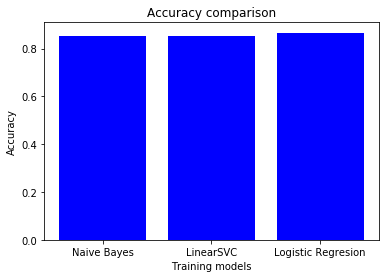

In [0]:
import matplotlib.pyplot as plt

x_axis_labels = ['Naive Bayes', 'LinearSVC', 'Logistic Regresion']
y_axis = [t['accuracy'] for t in test_results]
plt.bar([1,2,3], y_axis, color="blue")
plt.xlabel("Training models")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison")
plt.xticks([1, 2, 3], x_axis_labels)
plt.savefig('accu.png')
plt.show()

### 2. Runtime of Classification models

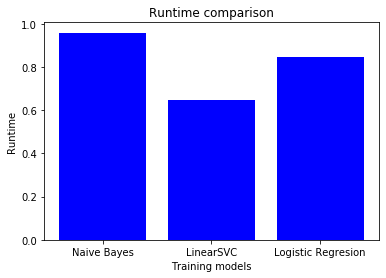

In [0]:
y_runtime = [t['runtime'] for t in test_results]
plt.bar([1,2,3], y_runtime, color="blue")
plt.xlabel("Training models")
plt.ylabel("Runtime")
plt.title("Runtime comparison")
plt.xticks([1, 2, 3], x_axis_labels)
plt.savefig('runtime.png')
plt.show()

### 3. Export Kaggle test result

### 1. Compute predictions using Logistic Regression

In [0]:
kaggle_pred = lr.predict(actual_test)


### 2. Format and Export the results

In [0]:
result_df = pd.DataFrame()
result_df["id"] = list(range(len(kaggle_pred)))
result_df["sentiment"] = kaggle_pred
result_df["sentiment"] = result_df["sentiment"].astype("category")
result_df["sentiment"].cat.categories = ["negative", "positive"]
result_df.to_csv("kaggle_submission.csv", index=False)
result_df

,id,sentiment
0,0,positive
1,1,positive
2,2,positive
3,3,negative
4,4,positive
...,...,...
9995,9995,positive
9996,9996,positive
9997,9997,negative
9998,9998,negative


## Extra: GloVe: Global Vectors for Word Representation

For this extra section, we describe our attempts to use pretrained Glove word embedding to vectorize the sentences.

[Download the trained word embedding here](http://nlp.stanford.edu/data/glove.twitter.27B.zip)

Extract and upload the 200 dimensions word embedding to colab environment.

Using this model, we have each word to map with a 200 dimensional vector, which can be used to create the feature matrix

In [0]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import normalize

In [0]:
# load embedding
def load(filename):
	with open(filename,'r') as f:
	  lines = f.readlines()

	embedding = dict()
	for line in lines:
		features = line.split()
		embedding[features[0]] = np.asarray(features[1:], dtype='float32')
	return embedding

embedding = load('glove.twitter.27B.200d.txt')

In [0]:
# Tokenize all words in the train and test data
all_reviews=train_df['review'].append(test_df['review'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_reviews)

In [0]:
vocab = list(tokenizer.word_index.keys())
vocab_filtered = [word for word in vocab if len(word) > 2]

In [0]:
# Vectorize all sentences using the pretrained models
num_features = 200
def vectorize(sentences, num_features):
  mat = np.zeros((len(sentences), num_features))
  for i, sentence in enumerate(sentences):
    vectors = np.array([embedding[word] for word in sentence.split(" ") if word in embedding])
    if len(vectors) != 0:
      mat[i] = np.sum(vectors, axis=0)
  return mat

# Each sentence is the normalized sum of the pretrained global vectors of all words
X_train = normalize(vectorize(train_df['review'], num_features))
X_test = normalize(vectorize(test_df['review'], num_features))

In [68]:
# Test with logistic regression
lr = LogisticRegression(max_iter=3000, C=0.05)
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(X_train, train_df.sentiment, test_size=0.2, random_state=111)

train_data = x_train_df, y_train_df
test_data = x_test_df, y_test_df

lr_y_pred_glove, lr_runtime_glove = test_model(lr, train_data, test_data)

lr_accu_glove = calculate_accuracy(y_test, lr_y_pred_glove)
test_results.append({'accuracy': lr_accu, 'runtime': lr_runtime_glove})

Training score: [0.74166667 0.75791667 0.74666667 0.73666667 0.73166667]
              precision    recall  f1-score   support

    positive       0.74      0.75      0.75      2991
    negative       0.75      0.74      0.74      3009

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000



### Conclusion:

The attempt to use pre-trained GloVe word embedding seems to not have the good result . One possible reason is that the model we used is too general, and we belive we could achieve a better result if we can instead train the glove word embedding using our own review vocabulary.